In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import transforms, datasets
import torch.optim as optim
import torch.nn.functional as tfunc
from torch.utils.data import Dataset
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image
import torch.nn.functional as func
from util_datasets import GaussianNoise, UniformNoise
import csv

from sklearn.metrics.ranking import roc_auc_score
import sklearn.metrics as metrics
import random
import seaborn
import matplotlib.pyplot as plt

%load_ext autoreload

%autoreload 2

from trainer import CheXpertTrainer 
from chexpertClass import CheXpertData
from denseNet121 import DenseNet121
from utils import *
from ood_evaluate import *
from denseNet121_v2 import *

In [2]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(123)
device = torch.device("cuda" if use_cuda else "cpu")


class_names = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 
               'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 
               'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']

imgtransResize = (320, 320)
imgtransCrop = 224

In [3]:
#TRANSFORM DATA SEQUENCE
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
transformList = []
#transformList.append(transforms.Resize(imgtransCrop))
transformList.append(transforms.RandomResizedCrop(imgtransCrop))
transformList.append(transforms.RandomHorizontalFlip())
transformList.append(transforms.ToTensor())
transformList.append(normalize)      
transformSequence=transforms.Compose(transformList)

In [4]:
#CheXpert dataset loading
chex_datasetValid = CheXpertData('datasets/chexpert-small/CheXpert-v1.0-small/valid.csv',transformSequence, preload = True, policy="ones")
chex_datasetTrain = CheXpertData('datasets/chexpert-small/CheXpert-v1.0-small/train.csv',transformSequence, policy="ones")
print("Train set: ", len(chex_datasetTrain))
print("Valid set: ", len(chex_datasetValid))
datasetValid, datasetTrain = random_split(chex_datasetTrain, [766, len(chex_datasetTrain) - 766])
chex_test, chex_train = random_split(datasetTrain, [1000, len(datasetTrain) - 1000])

#split datasets into train,valid,test
chex_valid = torch.utils.data.ConcatDataset([chex_datasetValid, datasetValid])
print("New train set: ", len(chex_train))
print("New valid set: ", len(chex_valid))
print("New test set: ", len(chex_test))
dataLoaderTrain = DataLoader(dataset=chex_train, batch_size=16, shuffle=True,  num_workers=1, pin_memory=True)
dataLoaderValid = DataLoader(dataset=chex_valid, batch_size=16, shuffle=False,  num_workers=1, pin_memory=True)
dataLoaderTest = DataLoader(dataset=chex_test, batch_size=16, shuffle=False,  num_workers=0, pin_memory=True)

Train set:  223414
Valid set:  234
New train set:  221648
New valid set:  1000
New test set:  1000


In [5]:
#NIH dataset loading
nih_dataset = datasets.ImageFolder(root='datasets/nih-small/small', transform = transformSequence)
nih_test, nih_train = random_split(nih_dataset, [1000, len(nih_dataset) - 1000])
print("NIH train set: ", len(nih_train))
print("NIH valid set: ", len(nih_test))
dataLoaderNIH = DataLoader(dataset=nih_test, batch_size=16, shuffle=False,  num_workers=0, pin_memory=True)

NIH train set:  4606
NIH valid set:  1000


### Confidence Evaluation of A Model Trained by Using Pretrained Weights

In [4]:
model = DenseNet121(len(class_names)).to(device)
model = torch.nn.DataParallel(model).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
checkpoint_path = 'checkpoints/epoch3.pth.tar'
train_loss, eval_loss, lables_v1, preds_v1 = load_checkpoint_v2(checkpoint_path, model, optimizer, use_cuda)

model loaded from checkpoints/epoch3.pth.tar


In [8]:
ind_scores, ind_gt, ind_conf = evaluate_ood(dataLoaderTest, 'confidence', model, device)
ood_scores, _, ood_conf = evaluate_ood(dataLoaderNIH, 'confidence', model, device)

100%|██████████| 63/63 [01:15<00:00,  1.04s/it]


In [9]:
ood_gt = np.zeros((ood_scores.shape[0], ood_scores.shape[1]))
labels = np.concatenate([ind_gt, ood_gt])
scores = np.concatenate([ind_scores, ood_scores])
confidences = np.concatenate([ind_conf,ood_conf])
ind_conf_labels = np.ones(ind_scores.shape[0])
ood_conf_labels = np.zeros(ood_scores.shape[0])
conf_labels = np.concatenate([ind_conf_labels,ood_conf_labels])

In [12]:
fpr = tpr76(ind_conf, ood_conf)
detection_error, best_delta = detection(ind_conf, ood_conf)
auroc = metrics.roc_auc_score(conf_labels, confidences)
aupr_in = metrics.average_precision_score(conf_labels, confidences)
aupr_out = metrics.average_precision_score(-1 * conf_labels + 1, 1 - confidences)

print("")
print("Method: confidence")
print("TPR75 (lower is better): ", fpr)
print("Detection error (lower is better): ", detection_error)
print("Best threshold:", best_delta)
print("AUROC (higher is better): ", auroc)
print("AUPR_IN (higher is better): ", aupr_in)
print("AUPR_OUT (higher is better): ", aupr_out)



Method: confidence
TPR75 (lower is better):  0.934889937106919
Detection error (lower is better):  0.5
Best threshold: 0.6073993444442749
AUROC (higher is better):  0.282019
AUPR_IN (higher is better):  0.37026724309557835
AUPR_OUT (higher is better):  0.3708137312531208


### Confidence Evaluation of A Model Trained From Scratch

In [19]:
model = DenseNet121(len(class_names)).to(device)
model = torch.nn.DataParallel(model).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
checkpoint_path = 'checkpoints/unpretrained_epoch3.pth.tar'
train_loss, eval_loss, lables_v1, preds_v1 = load_checkpoint_v2(checkpoint_path, model, optimizer, use_cuda)

ind_scores, ind_gt, ind_conf = evaluate_ood(dataLoaderTest, 'confidence_scaling', model, device)
ood_scores, _, ood_conf = evaluate_ood(dataLoaderNIH, 'confidence_scaling', model, device)

  0%|          | 0/63 [00:00<?, ?it/s]

model loaded from checkpoints/unpretrained_epoch3.pth.tar


100%|██████████| 63/63 [01:12<00:00,  1.03s/it]


In [20]:
ood_gt = np.zeros((ood_scores.shape[0], ood_scores.shape[1]))
labels = np.concatenate([ind_gt, ood_gt])
scores = np.concatenate([ind_scores, ood_scores])
confidences = np.concatenate([ind_conf,ood_conf])
ind_conf_labels = np.ones(ind_scores.shape[0])
ood_conf_labels = np.zeros(ood_scores.shape[0])
conf_labels = np.concatenate([ind_conf_labels,ood_conf_labels])

In [21]:
fpr = tpr76(ind_conf, ood_conf)
detection_error, best_delta = detection(ind_conf, ood_conf)
auroc = metrics.roc_auc_score(conf_labels, confidences)
aupr_in = metrics.average_precision_score(conf_labels, confidences)
aupr_out = metrics.average_precision_score(-1 * conf_labels + 1, 1 - confidences)

print("")
print("Method: confidence")
print("TPR75 (lower is better): ", fpr)
print("Detection error (lower is better): ", detection_error)
print("Best threshold:", best_delta)
print("AUROC (higher is better): ", auroc)
print("AUPR_IN (higher is better): ", aupr_in)
print("AUPR_OUT (higher is better): ", aupr_out)


Method: confidence
TPR75 (lower is better):  0.951413005272412
Detection error (lower is better):  0.5
Best threshold: 0.6163953542709351
AUROC (higher is better):  0.24683999999999998
AUPR_IN (higher is better):  0.3572174201419757
AUPR_OUT (higher is better):  0.3584638556614558


#### Confidence evaluation using predictions instead of confidence values

In [22]:
ood_gt = np.zeros((ood_scores.shape[0], ood_scores.shape[1]))
labels = np.concatenate([ind_gt, ood_gt])
scores = np.concatenate([ind_scores, ood_scores])

numClasses = 14
stat = {
    'fpr_at_76_tpr' : 0,
    'detection_error' : 0,
    'best_delta' : 0,
}
st_cnt = 0

metric = {
    'auroc' : 0,
    'aupr_in' : 0,
    'aupr_out' : 0,
}
met_cnt = 0

for i in range(numClasses):
    mask = ind_gt[:,i] == 1
    ind = ind_scores[:,i][mask]
    ood = ood_scores[:,i][mask]
    print(ind.size)
    if ind.size != 0:
        stat['fpr_at_76_tpr'] += tpr76(ind, ood)
        detection_error, best_delta = detection(ind, ood)
        stat['detection_error'] += detection_error
        stat['best_delta'] += best_delta
        st_cnt += 1
    try:
        metric['auroc'] += metrics.roc_auc_score(labels[:,i], scores[:,i])
        metric['aupr_in'] += metrics.average_precision_score(labels[:,i], scores[:,i])
        metric['aupr_out'] += metrics.average_precision_score(-1 * labels[:,i] + 1, 1 - scores[:,i])
        met_cnt += 1
    except ValueError:
        pass

stat = {k: v / st_cnt for k, v in stat.items()}
metric = {k: v / met_cnt for k, v in metric.items()}

print("")
print("Method: baseline")
print("TPR75 (lower is better): ", stat['fpr_at_76_tpr'])
print("Detection error (lower is better): ", stat['detection_error'])
print("Best threshold:", stat['best_delta'])
print("AUROC (higher is better): ", metric['auroc'])
print("AUPR_IN (higher is better): ", metric['aupr_in'])
print("AUPR_OUT (higher is better): ", metric['aupr_out'])

79
102
149
497
57
284
223
102
297
115
473
21
43
541

Method: baseline
TPR75 (lower is better):  0.28059095705516107
Detection error (lower is better):  0.25897588981709463
Best threshold: 0.15850204395450543
AUROC (higher is better):  0.77564338001049
AUPR_IN (higher is better):  0.28178439670646055
AUPR_OUT (higher is better):  0.9680079558338976


### Confindence Evaluation with Confidence branch giving non-scalar values

In [8]:
model = DenseNet121v2(len(class_names)).to(device)
model = torch.nn.DataParallel(model).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
checkpoint_path = 'checkpoints/new_model_epoch3.pth.tar'
train_loss, eval_loss, lables_v1, preds_v1 = load_checkpoint_v2(checkpoint_path, model, optimizer, use_cuda)

ind_scores, ind_gt, ind_conf = evaluate_ood(dataLoaderTest, 'confidence', model, device)
ood_scores, _, ood_conf = evaluate_ood(dataLoaderNIH, 'confidence', model, device)

  0%|          | 0/63 [00:00<?, ?it/s]

model loaded from checkpoints/new_model_epoch3.pth.tar


100%|██████████| 63/63 [01:13<00:00,  1.04s/it]


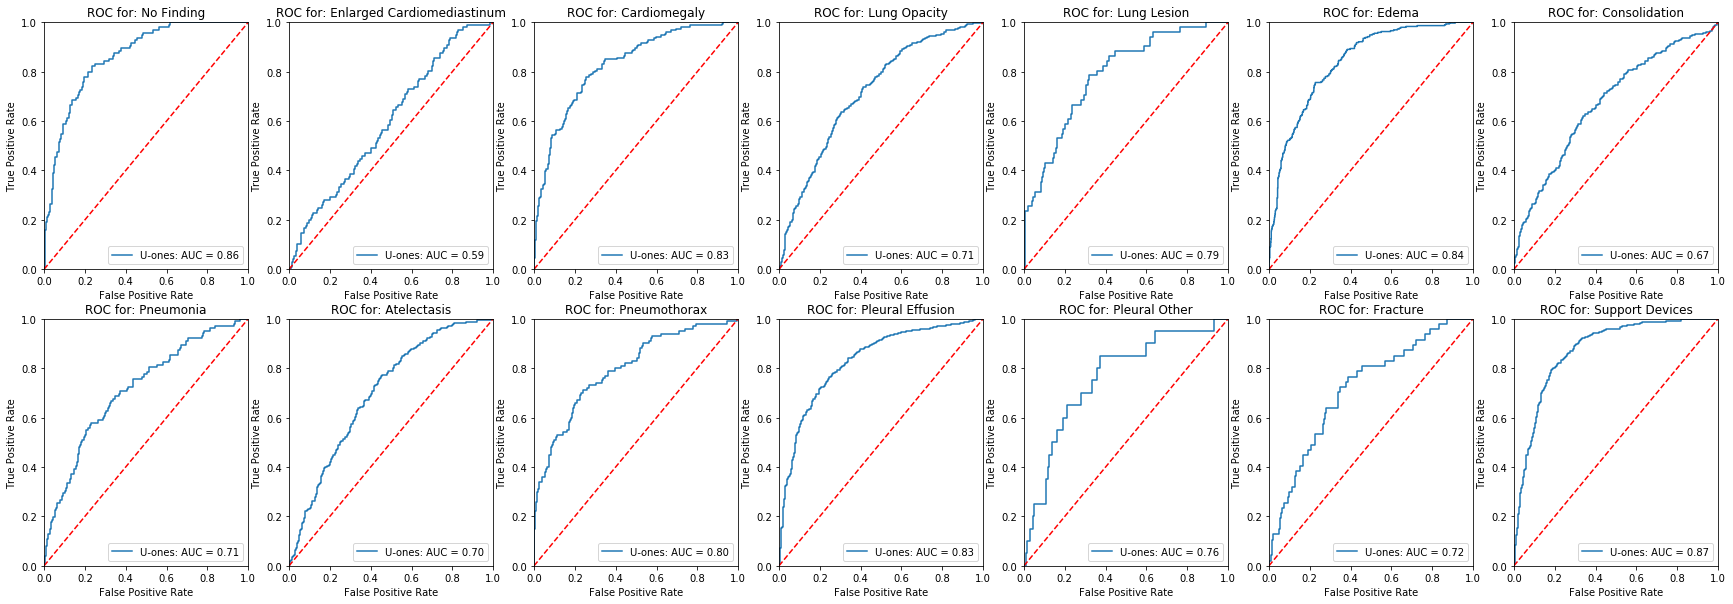

In [10]:
import matplotlib.pyplot as plt
import numpy as np
##PLOT AUC RESULTS
for i in range(len(class_names)):
    fpr, tpr, threshold = metrics.roc_curve(ind_gt[:,i], ind_scores[:,i])
    roc_auc = metrics.auc(fpr, tpr)
    f = plt.subplot(2, 7, i+1)
    #fpr2, tpr2, threshold2 = metrics.roc_curve(outGT3.cpu()[:,i], outPRED3.cpu()[:,i])
    #roc_auc2 = metrics.auc(fpr2, tpr2)
    #fpr3, tpr3, threshold2 = metrics.roc_curve(outGT4.cpu()[:,i], outPRED4.cpu()[:,i])
    #roc_auc3 = metrics.auc(fpr3, tpr3)


    plt.title('ROC for: ' + class_names[i])
    plt.plot(fpr, tpr, label = 'U-ones: AUC = %0.2f' % roc_auc)
    #plt.plot(fpr2, tpr2, label = 'U-zeros: AUC = %0.2f' % roc_auc2)
    #plt.plot(fpr3, tpr3, label = 'AUC = %0.2f' % roc_auc3)

    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 30
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

plt.savefig("ROC1345.png", dpi=1000)
plt.show()


Method: Confidence
TPR75 (lower is better):  0.16145404814004258
Detection error (lower is better):  0.2
Best threshold: 0.303068736923933
AUROC (higher is better):  0.8649775
AUPR_IN (higher is better):  0.858251217234561
AUPR_OUT (higher is better):  0.8161619166432693


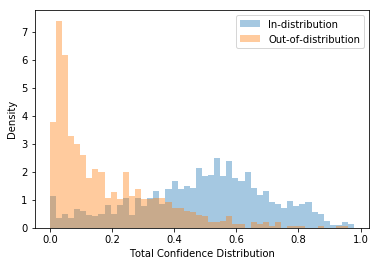

In [9]:
conf_ind = ind_gt * ind_scores
conf_ood = ind_gt * ood_scores
conf_ind = np.sum(conf_ind, axis = 1) / (np.sum(ind_gt, axis = 1) + 1e-10)
conf_ood = np.sum(conf_ood, axis = 1) / (np.sum(ind_gt, axis = 1) + 1e-10)

ood_labels = np.zeros((conf_ood.shape[0]))
ind_labels = np.ones((conf_ind.shape[0]))
labels = np.concatenate([ind_labels, ood_labels])
scores = np.concatenate([conf_ind,conf_ood])
stat = {
    'fpr_at_76_tpr' : 0,
    'detection_error' : 0,
    'best_delta' : 0,
}

metric = {
    'auroc' : 0,
    'aupr_in' : 0,
    'aupr_out' : 0,
}


stat['fpr_at_76_tpr'] = tpr76(conf_ind, conf_ood)
stat['detection_error'], stat['best_delta'] = detection(conf_ind, conf_ood)
#try:
metric['auroc'] = metrics.roc_auc_score(labels, scores)
metric['aupr_in'] = metrics.average_precision_score(labels, scores)
metric['aupr_out'] = metrics.average_precision_score(-1 * labels + 1, 1 - scores)
#except ValueError:
#    pass

print("")
print("Method: Confidence")
print("TPR75 (lower is better): ", stat['fpr_at_76_tpr'])
print("Detection error (lower is better): ", stat['detection_error'])
print("Best threshold:", stat['best_delta'])
print("AUROC (higher is better): ", metric['auroc'])
print("AUPR_IN (higher is better): ", metric['aupr_in'])
print("AUPR_OUT (higher is better): ", metric['aupr_out'])

ranges = (np.min(scores), np.max(scores))
seaborn.distplot(conf_ind.ravel(), hist_kws={'range': ranges}, kde=False, bins=50, norm_hist=True, label='In-distribution')
seaborn.distplot(conf_ood.ravel(), hist_kws={'range': ranges}, kde=False, bins=50, norm_hist=True, label='Out-of-distribution')
plt.xlabel('Total Confidence Distribution')
plt.ylabel('Density')
plt.legend()
plt.show()

#### Evaluation with "Confidence Scaling"

In [15]:
model = DenseNet121v2(len(class_names)).to(device)
model = torch.nn.DataParallel(model).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
checkpoint_path = 'checkpoints/new_model_epoch3.pth.tar'
train_loss, eval_loss, lables_v1, preds_v1 = load_checkpoint_v2(checkpoint_path, model, optimizer, use_cuda)

ind_scores, ind_gt, ind_conf = evaluate_ood(dataLoaderTest, 'confidence_scaling', model, device)
ood_scores, _, ood_conf = evaluate_ood(dataLoaderNIH, 'confidence_scaling', model, device)

  0%|          | 0/63 [00:00<?, ?it/s]

model loaded from checkpoints/new_model_epoch3.pth.tar


100%|██████████| 63/63 [01:10<00:00,  1.00s/it]



Method: Confidence Scaling
TPR75 (lower is better):  0.28753057553956646
Detection error (lower is better):  0.264
Best threshold: 0.2507963452774286
AUROC (higher is better):  0.7991595
AUPR_IN (higher is better):  0.7905019875114223
AUPR_OUT (higher is better):  0.7491937130720473


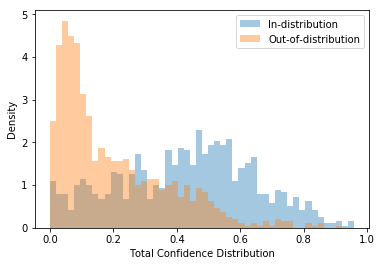

In [16]:
conf_ind = ind_gt * ind_scores
conf_ood = ind_gt * ood_scores
conf_ind = np.sum(conf_ind, axis = 1) / (np.sum(ind_gt, axis = 1) + 1e-10)
conf_ood = np.sum(conf_ood, axis = 1) / (np.sum(ind_gt, axis = 1) + 1e-10)

ood_labels = np.zeros((conf_ood.shape[0]))
ind_labels = np.ones((conf_ind.shape[0]))
labels = np.concatenate([ind_labels, ood_labels])
scores = np.concatenate([conf_ind,conf_ood])
stat = {
    'fpr_at_76_tpr' : 0,
    'detection_error' : 0,
    'best_delta' : 0,
}

metric = {
    'auroc' : 0,
    'aupr_in' : 0,
    'aupr_out' : 0,
}


stat['fpr_at_76_tpr'] = tpr76(conf_ind, conf_ood)
stat['detection_error'], stat['best_delta'] = detection(conf_ind, conf_ood)
#try:
metric['auroc'] = metrics.roc_auc_score(labels, scores)
metric['aupr_in'] = metrics.average_precision_score(labels, scores)
metric['aupr_out'] = metrics.average_precision_score(-1 * labels + 1, 1 - scores)
#except ValueError:
#    pass

print("")
print("Method: Confidence Scaling")
print("TPR75 (lower is better): ", stat['fpr_at_76_tpr'])
print("Detection error (lower is better): ", stat['detection_error'])
print("Best threshold:", stat['best_delta'])
print("AUROC (higher is better): ", metric['auroc'])
print("AUPR_IN (higher is better): ", metric['aupr_in'])
print("AUPR_OUT (higher is better): ", metric['aupr_out'])

ranges = (np.min(scores), np.max(scores))
seaborn.distplot(conf_ind.ravel(), hist_kws={'range': ranges}, kde=False, bins=50, norm_hist=True, label='In-distribution')
seaborn.distplot(conf_ood.ravel(), hist_kws={'range': ranges}, kde=False, bins=50, norm_hist=True, label='Out-of-distribution')
plt.xlabel('Total Confidence Distribution')
plt.ylabel('Density')
plt.legend()
plt.show()

#### Evaluation with ODIN

In [6]:
model = DenseNet121(len(class_names)).to(device)
model = torch.nn.DataParallel(model).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
checkpoint_path = 'cheXpert_github/model_ones_3epoch_densenet.tar'
load_checkpoint(checkpoint_path, model, optimizer, use_cuda)

ind_scores, ind_gt, ind_conf = evaluate_ood(dataLoaderTest, 'odin', model, device)
ood_scores, _, ood_conf = evaluate_ood(dataLoaderNIH, 'odin', model, device)

  0%|          | 0/63 [00:00<?, ?it/s]

model loaded from cheXpert_github/model_ones_3epoch_densenet.tar


100%|██████████| 63/63 [01:12<00:00,  1.03s/it]



Method: ODIN
TPR75 (lower is better):  0.1862258064516156
Detection error (lower is better):  0.2145
Best threshold: 0.34567208146452905
AUROC (higher is better):  0.8520705
AUPR_IN (higher is better):  0.8489706724393755
AUPR_OUT (higher is better):  0.8049376946795319


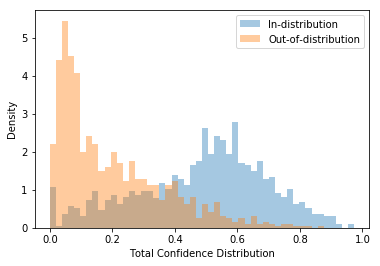

In [7]:
conf_ind = ind_gt * ind_scores
conf_ood = ind_gt * ood_scores
conf_ind = np.sum(conf_ind, axis = 1) / (np.sum(ind_gt, axis = 1) + 1e-10)
conf_ood = np.sum(conf_ood, axis = 1) / (np.sum(ind_gt, axis = 1) + 1e-10)

ood_labels = np.zeros((conf_ood.shape[0]))
ind_labels = np.ones((conf_ind.shape[0]))
labels = np.concatenate([ind_labels, ood_labels])
scores = np.concatenate([conf_ind,conf_ood])
stat = {
    'fpr_at_76_tpr' : 0,
    'detection_error' : 0,
    'best_delta' : 0,
}

metric = {
    'auroc' : 0,
    'aupr_in' : 0,
    'aupr_out' : 0,
}


stat['fpr_at_76_tpr'] = tpr76(conf_ind, conf_ood)
stat['detection_error'], stat['best_delta'] = detection(conf_ind, conf_ood)
#try:
metric['auroc'] = metrics.roc_auc_score(labels, scores)
metric['aupr_in'] = metrics.average_precision_score(labels, scores)
metric['aupr_out'] = metrics.average_precision_score(-1 * labels + 1, 1 - scores)
#except ValueError:
#    pass

print("")
print("Method: ODIN")
print("TPR75 (lower is better): ", stat['fpr_at_76_tpr'])
print("Detection error (lower is better): ", stat['detection_error'])
print("Best threshold:", stat['best_delta'])
print("AUROC (higher is better): ", metric['auroc'])
print("AUPR_IN (higher is better): ", metric['aupr_in'])
print("AUPR_OUT (higher is better): ", metric['aupr_out'])

ranges = (np.min(scores), np.max(scores))
seaborn.distplot(conf_ind.ravel(), hist_kws={'range': ranges}, kde=False, bins=50, norm_hist=True, label='In-distribution')
seaborn.distplot(conf_ood.ravel(), hist_kws={'range': ranges}, kde=False, bins=50, norm_hist=True, label='Out-of-distribution')
plt.xlabel('Total Confidence Distribution')
plt.ylabel('Density')
plt.legend()
plt.show()

### HEATMAP GENERATION FOR QUALITATIVE INTERPRETATION

model loaded from checkpoints/new_model_epoch3.pth.tar


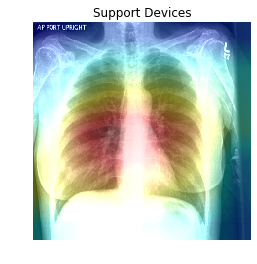

In [22]:
from heat_map import *
pathInputImage = "view1_frontal.jpg"
pathOutputImage = 'heatmap_view1_frontal.png'
pathModel = 'checkpoints/new_model_epoch3.pth.tar'


h = HeatmapGenerator(pathModel, class_names, imgtransCrop, device, use_cuda)

h.generate(pathInputImage, pathOutputImage, imgtransCrop)

model loaded from checkpoints/new_model_epoch3.pth.tar


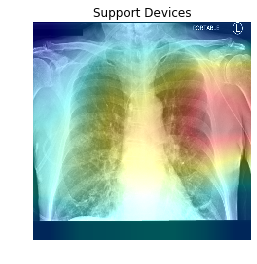

In [23]:
pathInputImage = "00019765_010.png"
pathOutputImage = 'heatmap_nih.png'
pathModel = 'checkpoints/new_model_epoch3.pth.tar'


h = HeatmapGenerator(pathModel, class_names, imgtransCrop, device, use_cuda)

h.generate(pathInputImage, pathOutputImage, imgtransCrop)